In [2]:
import osm_loader

bbox=[41.3752, 2.0354, 41.3889, 2.0586]

In [3]:
network = osm_loader.load_network('sant_feliu', bbox)

In [4]:
pois = osm_loader.load_pois('sant_feliu', bbox)

In [5]:
category_gb = pois.groupby(by=['key'])

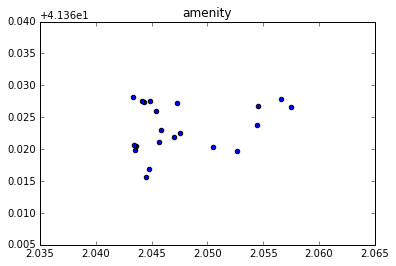

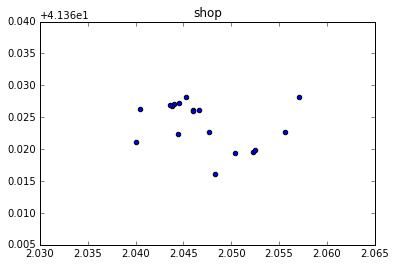

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
for category, items in category_gb:
    fig, axes = plt.subplots()
    plt.title(category)
    plt.scatter(items['lon'], items['lat'])
    plt.show()

for category, items in category_gb:
    plt.figure()
    plt.title(category)
    sns.kdeplot(items['lon'], items['lat'])


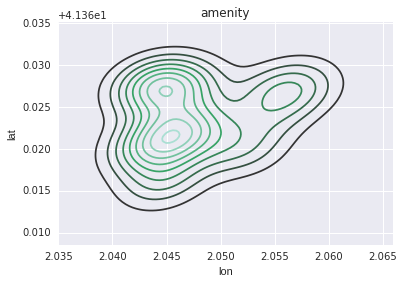

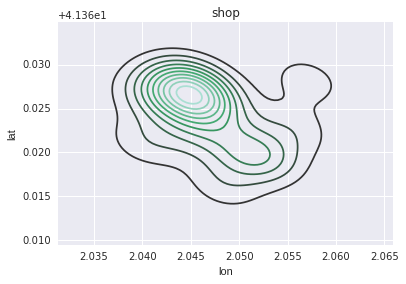

In [7]:
import seaborn as sns

%matplotlib inline
for category, items in category_gb:
    plt.figure()
    plt.title(category)
    sns.kdeplot(items['lon'], items['lat'])

In [8]:
import pandas as pd
from sklearn.neighbors.kde import KernelDensity

nodes_array = network.nodes_df[['x','y']].values
kde_df = pd.DataFrame(index=network.nodes_df.index)

for category, items in category_gb:
    kde = KernelDensity()
    kde.fit(items[['lon','lat']].values)
    category_density_array = kde.score_samples(nodes_array)
    kde_df[category] = category_density_array

In [9]:
from geo_graph import GeoGraph

g = GeoGraph(network)

In [10]:
import networkx as nx

bc = nx.betweenness_centrality(g._G)
cc = nx.closeness_centrality(g._G)
dc = nx.degree_centrality(g._G)

centrality_df = pd.DataFrame({'betweenness': bc, 'closeness': cc, 'degree': dc})
centrality_df.index = centrality_df.index.map(lambda geo_node: geo_node.id)

In [11]:
nearest_centrality_df = pd.concat([
    pd.DataFrame({ key: value for (key, value) in zip(kde_df.columns, list(map(kde_df.__getitem__, kde_df.columns))) }),
    centrality_df], axis=1)
nearest_centrality_df.head()

           amenity      shop  betweenness  closeness    degree
30267211 -1.837945 -1.837941     0.013327   0.045545  0.007092
30267212 -1.837934 -1.837929     0.007188   0.047171  0.007092
30267213 -1.837923 -1.837919     0.036532   0.044560  0.009456
30267217 -1.837930 -1.837927     0.010554   0.047575  0.009456
30267218 -1.837926 -1.837925     0.034953   0.046142  0.011820

In [12]:
nearest_centrality_df.corr()

              amenity      shop  betweenness  closeness    degree
amenity      1.000000  0.984892     0.136045  -0.334264  0.064567
shop         0.984892  1.000000     0.149529  -0.264403  0.066216
betweenness  0.136045  0.149529     1.000000   0.318083  0.320191
closeness   -0.334264 -0.264403     0.318083   1.000000  0.230198
degree       0.064567  0.066216     0.320191   0.230198  1.000000

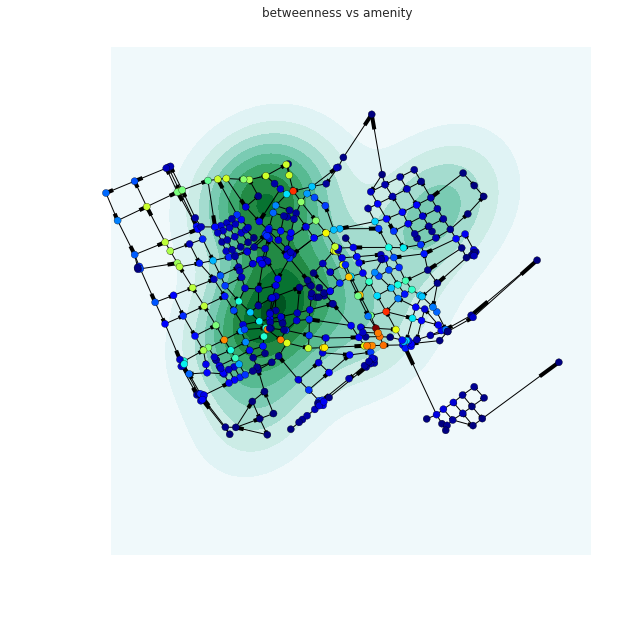

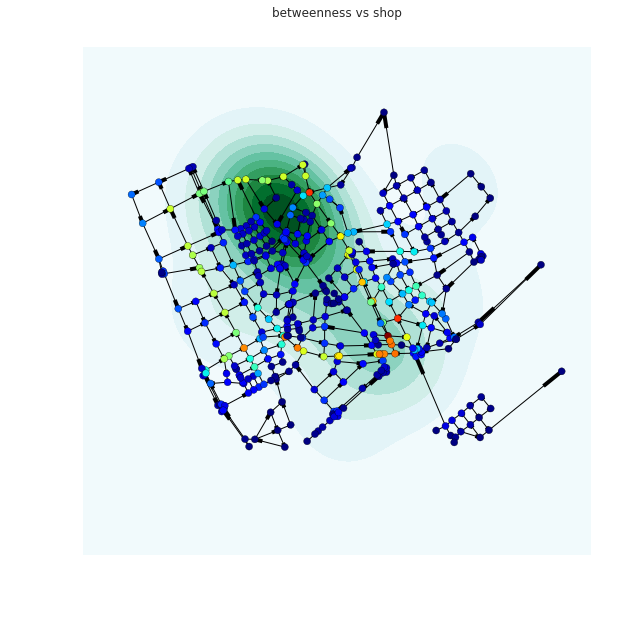

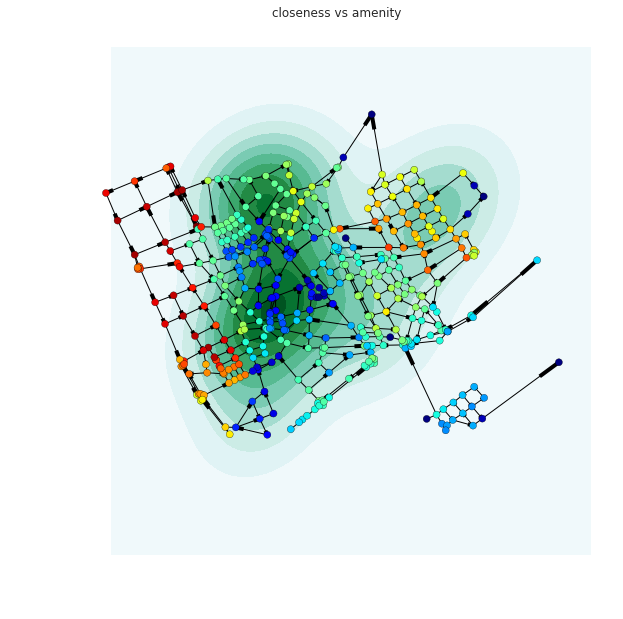

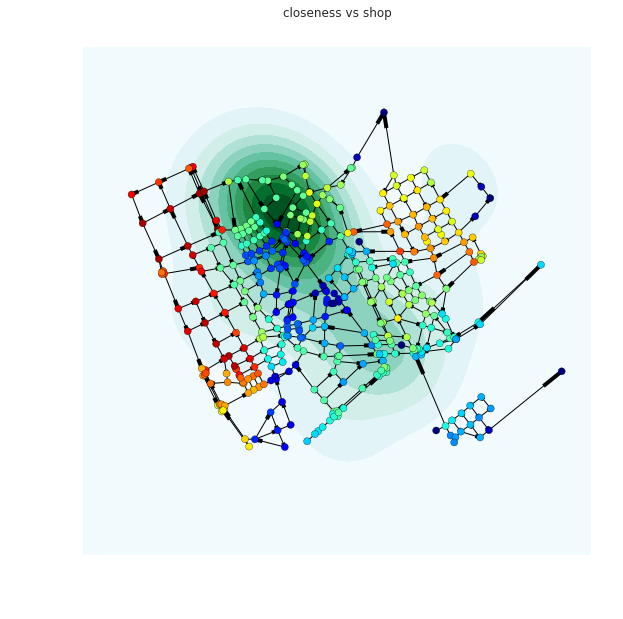

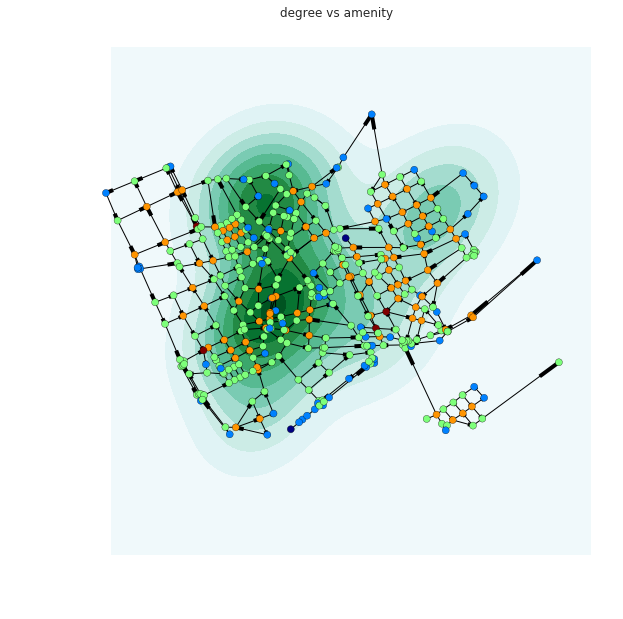

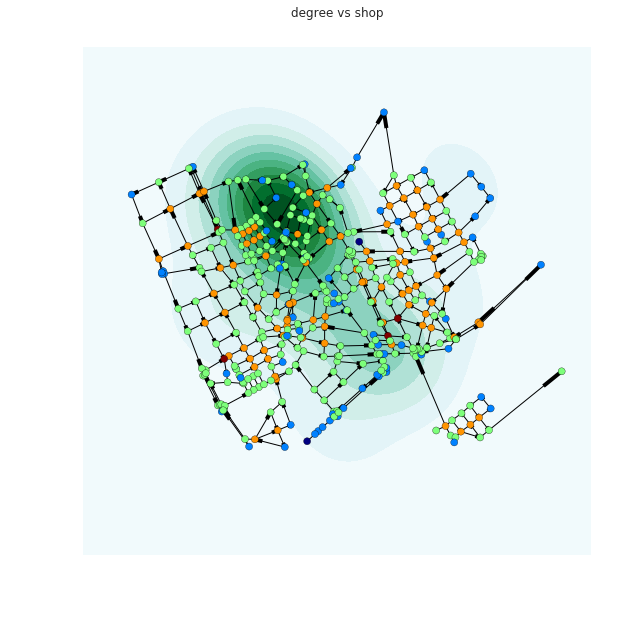

In [16]:
%matplotlib qt
cmap = plt.get_cmap('jet')

for centrality_label in centrality_df:
    for category_label, category_ser in category_gb:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title(centrality_label + ' vs ' + category_label)
        sns.kdeplot(category_ser['lon'], category_ser['lat'], ax=ax, legend=True, shade=True)
        g.plot(ax, node_color = [centrality_df[centrality_label][node.id] for node in g._G], node_size=50, cmap=cmap)